# Dataset Evaluation

We should check out the class distributions, image quality, general statistics, and fix any issues before moving forward

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import webdataset as wds

from PIL import Image, ImageEnhance

In [2]:
sns.set_style('darkgrid')

## Load Data

In [3]:
df = pd.read_csv('proj_labels.csv')
df.head()

,image,label,type
0,ESP_013049_0950_RED-0067.jpg,7,train
1,ESP_013049_0950_RED-0067-fv.jpg,7,train
2,ESP_013049_0950_RED-0067-brt.jpg,7,train
3,ESP_013049_0950_RED-0067-r90.jpg,7,train
4,ESP_013049_0950_RED-0067-r180.jpg,7,train


In [4]:
df.shape, df['image'].nunique()

((15088, 3), 12225)

In [5]:
df = df.drop_duplicates()

In [6]:
df.shape, df['image'].nunique()

((12225, 3), 12225)

**WHY YOU PUTTING DUPLICATES IN HERE NASA, YOU'RE MESSING UP MY DAY**

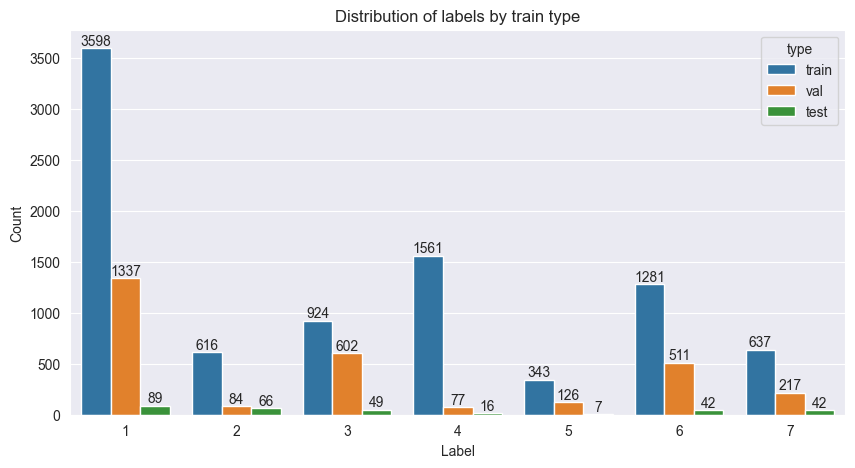

In [7]:
fig = plt.figure(figsize=(10, 5))

ax = sns.countplot(df, x='label', hue='type')
ax.set_title('Distribution of labels by train type')
ax.set_xlabel('Label')
ax.set_ylabel('Count')

for i in range(df['type'].nunique()):
    ax.bar_label(ax.containers[i])

plt.show()

However since train and validation go through an augmentation with an additional 6 images per base image we should scale down the representations to be on par with test

In [8]:
counts = (df[['label', 'type']]
          .groupby(['label', 'type'])
          .size()
          .reset_index()
          .rename(columns={0: "count"}))

train_or_val = counts['type'].isin({'train', 'val'})
counts.loc[train_or_val, 'count'] //= 7
counts.head()

,label,type,count
0,1,test,89
1,1,train,514
2,1,val,191
3,2,test,66
4,2,train,88


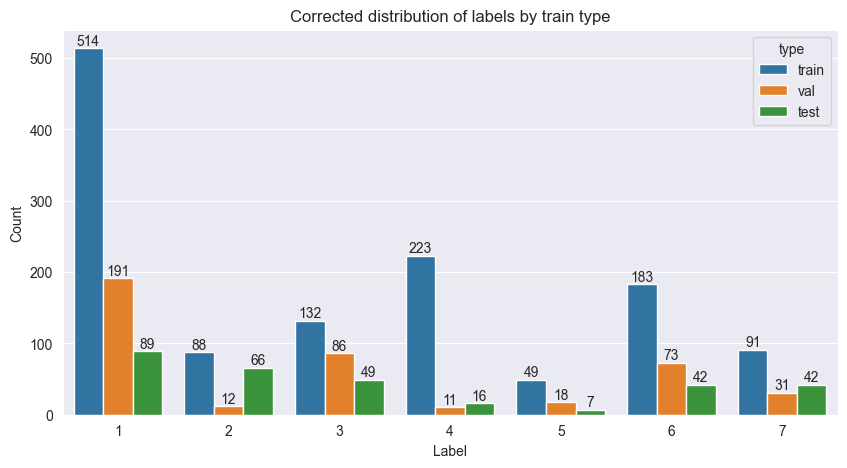

In [9]:
fig = plt.figure(figsize=(10, 5))

ax = sns.barplot(counts, x='label', y='count', hue='type', hue_order=['train', 'val', 'test'])
ax.set_title('Corrected distribution of labels by train type')
ax.set_xlabel('Label')
ax.set_ylabel('Count')

for i in range(df['type'].nunique()):
    ax.bar_label(ax.containers[i])

plt.show()

This would be more interesting to view as percentages of the splits

In [10]:
counts.head()

,label,type,count
0,1,test,89
1,1,train,514
2,1,val,191
3,2,test,66
4,2,train,88


In [11]:
def get_pct(group) -> float:
    row = group.iloc[0]
    return row['count'] / row['label_counts']

lbl_sums = (counts.groupby(['label'])['count']
            .sum()
            .reset_index()
            .rename(columns={'count': 'label_counts'}))

counts = pd.merge(counts, lbl_sums, on='label')

counts = (counts.groupby(['label', 'type'])[['count', 'label_counts']]
          .apply(get_pct)
          .reset_index()
          .rename(columns={0: "pct"}))

counts.head()

,label,type,pct
0,1,test,0.112091
1,1,train,0.647355
2,1,val,0.240554
3,2,test,0.397590
4,2,train,0.530120


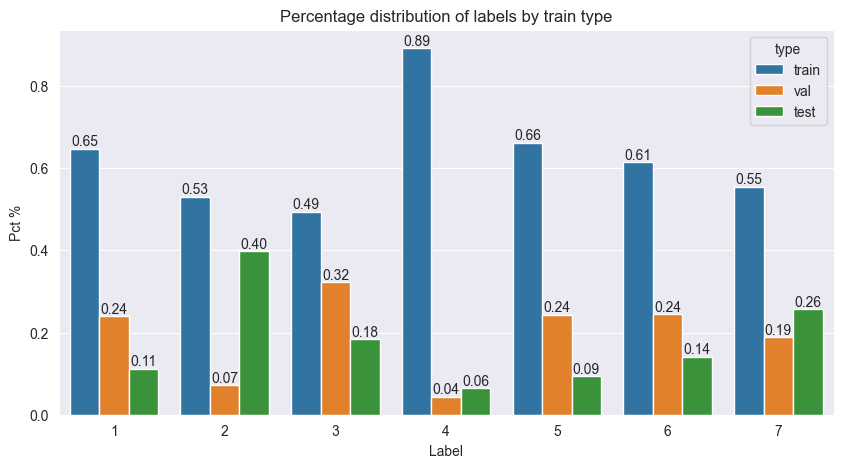

In [12]:
fig = plt.figure(figsize=(10, 5))

ax = sns.barplot(counts, x='label', y='pct', hue='type', hue_order=['train', 'val', 'test'])
ax.set_title('Percentage distribution of labels by train type')
ax.set_xlabel('Label')
ax.set_ylabel('Pct %')

for i in range(df['type'].nunique()):
    ax.bar_label(ax.containers[i], fmt="%.2f")

plt.show()

This shows clearly the original splits are not representative, there may have been a reason to specifically split in this way but we should also try a more evenly distributed set

## Dataset Corrections

In [13]:
df_base = pd.read_csv('base_proj_labels.csv')
df_lbl = pd.read_csv('labels.csv')

In [14]:
print(df_base.shape, df_base['base'].nunique())
print(df_lbl.shape, df_lbl['image'].nunique())

(2013, 4) 2013
(67810, 3) 64947


In [15]:
df_base = df_base.drop_duplicates()
df_lbl = df_lbl.drop_duplicates()

In [16]:
(df_base.shape, df_base['base'].nunique())

((2013, 4), 2013)

In [17]:
df_base = pd.merge(df_base, df_lbl, left_on='base', right_on='image', how='left')
df_base.head()

,base,artifact,rect,angle,image,label,type
0,ESP_011289_1950_RED-0009.jpg,True,"[2, 5, 226, 178]",0,ESP_011289_1950_RED-0009.jpg,3,test
1,ESP_011289_1950_RED-0044.jpg,False,"[0, 0, 227, 227]",0,ESP_011289_1950_RED-0044.jpg,3,test
2,ESP_011289_1950_RED-0066.jpg,False,"[0, 0, 227, 227]",0,ESP_011289_1950_RED-0066.jpg,3,test
3,ESP_011289_1950_RED-0092.jpg,False,"[0, 0, 227, 227]",0,ESP_011289_1950_RED-0092.jpg,1,test
4,ESP_011289_1950_RED-0102.jpg,False,"[0, 0, 227, 227]",0,ESP_011289_1950_RED-0102.jpg,3,test


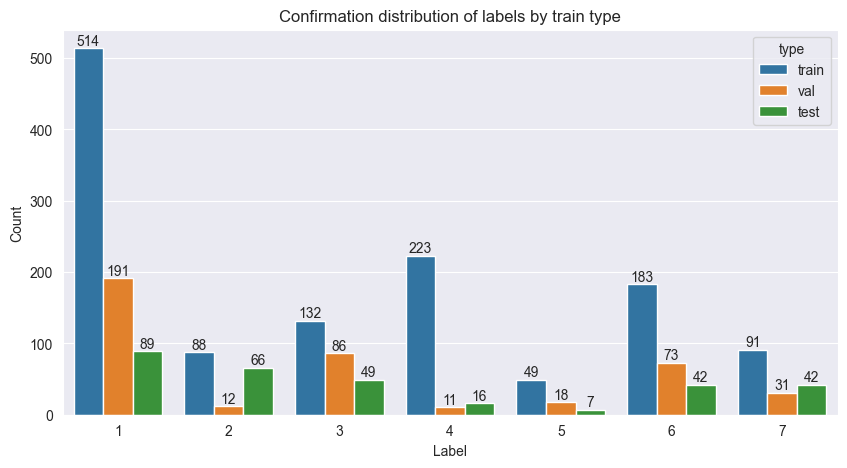

In [18]:
fig = plt.figure(figsize=(10, 5))

ax = sns.countplot(df_base, x='label', hue='type', hue_order=['train', 'val', 'test'])
ax.set_title('Confirmation distribution of labels by train type')
ax.set_xlabel('Label')
ax.set_ylabel('Count')

for i in range(df['type'].nunique()):
    ax.bar_label(ax.containers[i])

train_counts = ax.containers[0].datavalues
val_counts = ax.containers[1].datavalues
test_counts = ax.containers[2].datavalues

plt.show()

In [19]:
totals = train_counts + val_counts + test_counts
totals

array([794., 166., 267., 250.,  74., 298., 164.])

In [20]:
expected_train = np.round(totals * .6)
expected_val = np.round(totals * .2)
expected_test = totals - (expected_train + expected_val)

print('Expected train \tamounts:', expected_train)
print('Expected val \tamounts:', expected_val)
print('Expected test \tamounts:', expected_test)

Expected train 	amounts: [476. 100. 160. 150.  44. 179.  98.]
Expected val 	amounts: [159.  33.  53.  50.  15.  60.  33.]
Expected test 	amounts: [159.  33.  54.  50.  15.  59.  33.]


These are the distribution corrections we should make

In [21]:
train_changes = expected_train - train_counts
val_changes = expected_val - val_counts
test_changes = expected_test - test_counts

print('Changes train \tamounts:', train_changes)
print('Changes val \tamounts:', val_changes)
print('Changes test \tamounts:', test_changes)

Changes train 	amounts: [-38.  12.  28. -73.  -5.  -4.   7.]
Changes val 	amounts: [-32.  21. -33.  39.  -3. -13.   2.]
Changes test 	amounts: [ 70. -33.   5.  34.   8.  17.  -9.]


In [22]:
def sample_n_from_label(df, n, type, label):
    type_filter = (df['type'] == type)
    label_filter = (df['label'] == label)
    return df[type_filter & label_filter].sample(n=n, replace=False)

def sample_n_types_from_label(df, ns, types, label):
    samples = [sample_n_from_label(df, n, type, label) for n, type in zip(ns, types)]
    samples = pd.concat(samples)
    return samples.index

def split_index(idx, n):
    set_a = np.random.choice(idx, n, replace=False)
    set_b = np.setdiff1d(idx, set_a)
    return set_a, set_b

In [23]:
idx_1 = sample_n_types_from_label(df_base, [38, 32], ['train', 'val'], 1)
idx_2 = sample_n_types_from_label(df_base, [33], ['test'], 2)
idx_3 = sample_n_types_from_label(df_base, [33], ['val'], 3)
idx_4 = sample_n_types_from_label(df_base, [73], ['train'], 4)
idx_5 = sample_n_types_from_label(df_base, [5, 3], ['train', 'val'], 5)
idx_6 = sample_n_types_from_label(df_base, [4, 13], ['train', 'val'], 6)
idx_7 = sample_n_types_from_label(df_base, [9], ['test'], 7)

In [24]:
idx2_train, idx2_val = split_index(idx_2, 12)
idx3_train, idx3_test = split_index(idx_3, 28)
idx4_val, idx4_test = split_index(idx_4, 39)
idx7_train, idx7_val = split_index(idx_7, 7)

In [25]:
# correct distributions
df_base.loc[idx_1, 'type'] = 'test'
df_base.loc[idx2_train, 'type'] = 'train'
df_base.loc[idx2_val, 'type'] = 'val'
df_base.loc[idx3_train, 'type'] = 'train'
df_base.loc[idx3_test, 'type'] = 'test'
df_base.loc[idx4_val, 'type'] = 'val'
df_base.loc[idx4_test, 'type'] = 'test'
df_base.loc[idx_5, 'type'] = 'test'
df_base.loc[idx_6, 'type'] = 'test'
df_base.loc[idx7_train, 'type'] = 'train'
df_base.loc[idx7_val, 'type'] = 'val'

## View Corrections

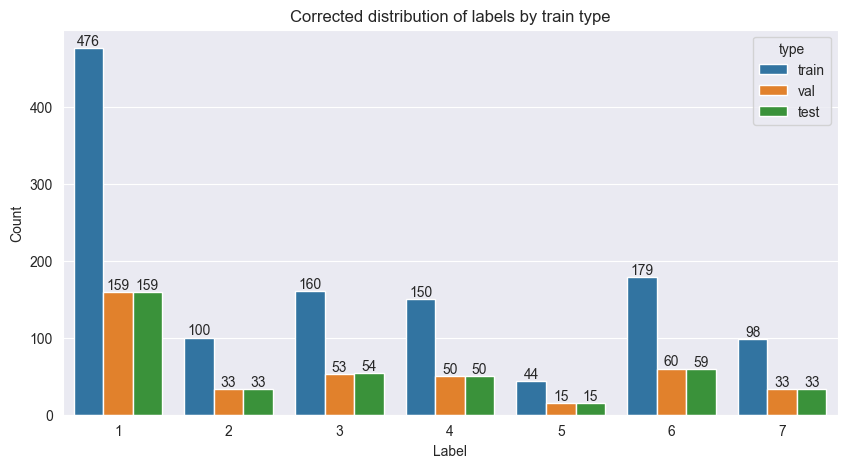

In [26]:
fig = plt.figure(figsize=(10, 5))

ax = sns.countplot(df_base, x='label', hue='type', hue_order=['train', 'val', 'test'])
ax.set_title('Corrected distribution of labels by train type')
ax.set_xlabel('Label')
ax.set_ylabel('Count')

for i in range(df['type'].nunique()):
    ax.bar_label(ax.containers[i])

plt.show()

In [27]:
def get_pct(group) -> float:
    return len(group) / group.iloc[0]

lbl_sums = (df_base.groupby(['label'])
            .size()
            .reset_index()
            .rename(columns={0: 'count'}))

counts = pd.merge(df_base, lbl_sums, on='label')

counts = (counts.groupby(['label', 'type'])['count']
          .apply(get_pct)
          .reset_index()
          .rename(columns={'count': "pct"}))

counts.head()

,label,type,pct
0,1,test,0.200252
1,1,train,0.599496
2,1,val,0.200252
3,2,test,0.198795
4,2,train,0.602410


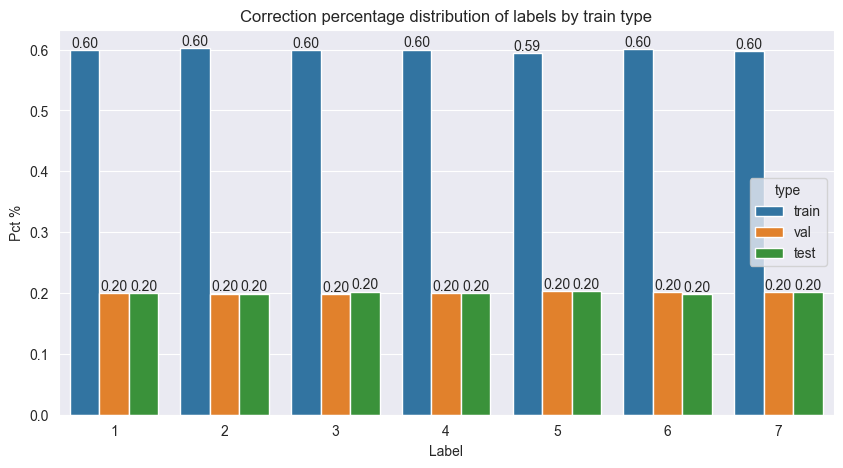

In [28]:
fig = plt.figure(figsize=(10, 5))

ax = sns.barplot(counts, x='label', y='pct', hue='type', hue_order=['train', 'val', 'test'])
ax.set_title('Correction percentage distribution of labels by train type')
ax.set_xlabel('Label')
ax.set_ylabel('Pct %')

for i in range(df['type'].nunique()):
    ax.bar_label(ax.containers[i], fmt="%.2f")

plt.show()

In [29]:
df_base[['image', 'label', 'type']].to_csv('corrected_proj_labels.csv', index=False)

## Apply Correction

In [30]:
plan = pd.read_csv('corrected_proj_labels.csv')
plan.head()

,image,label,type
0,ESP_011289_1950_RED-0009.jpg,3,test
1,ESP_011289_1950_RED-0044.jpg,3,test
2,ESP_011289_1950_RED-0066.jpg,3,test
3,ESP_011289_1950_RED-0092.jpg,1,test
4,ESP_011289_1950_RED-0102.jpg,3,test


In [31]:
(plan.shape, plan['image'].nunique())

((2013, 3), 2013)

In [32]:
def image_type_dict(df):
    image_type_lookup = {}

    for _, row in df.iterrows():
        image_type_lookup[row['image']] = row['type']
    
    return image_type_lookup

In [41]:
plan = image_type_dict(plan)

In [33]:
data_folder = './feature_data'

In [34]:
ds_train = (wds.WebDataset(f'file:{data_folder}/train-000000.tar', shardshuffle=True)
    .decode("pil")
    .to_tuple("jpg", "json"))

ds_val = (wds.WebDataset(f'file:{data_folder}/val-000000.tar', shardshuffle=True)
    .decode("pil")
    .to_tuple("jpg", "json"))

ds_test = (wds.WebDataset(f'file:{data_folder}/test-000000.tar', shardshuffle=True)
    .decode("pil")
    .to_tuple("jpg", "json"))

In [35]:
train_writer = wds.ShardWriter(f'file:{data_folder}/corrected/train-%06d.tar', maxcount=15_000, compress=True)
val_writer = wds.ShardWriter(f'file:{data_folder}/corrected/val-%06d.tar', maxcount=15_000, compress=True)
test_writer = wds.ShardWriter(f'file:{data_folder}/corrected/test-%06d.tar', maxcount=15_000, compress=True)

# writing file:./feature_data/corrected/train-000000.tar 0 0.0 GB 0
# writing file:./feature_data/corrected/val-000000.tar 0 0.0 GB 0
# writing file:./feature_data/corrected/test-000000.tar 0 0.0 GB 0


In [36]:
def get_writer(ttype: str):
    if ttype == 'train':
        return train_writer
    elif ttype == 'val':
        return val_writer

    return test_writer

def is_base(meta: dict) -> bool:
    return meta['base'] == meta['image']

def prepare_img(img: Image.Image, meta: dict) -> dict:
    return {
        '__key__': os.path.splitext(meta['image'])[0],
        'jpg': img,
        'json': meta
    }

def enhance_brt(img: Image.Image) -> Image.Image:
    enhancer = ImageEnhance.Brightness(img)
    factor = random.uniform(0.5, 1.5) # Random brightness factor between 0.5 and 1.5
    return enhancer.enhance(factor)

def transform_img(img: Image.Image, meta: dict, aug: str) -> tuple:
    aug_img_file = os.path.splitext(meta['image'])[0]
    aug_img_file = f'{aug_img_file}-{aug}.jpg'

    aug_meta = meta.copy()
    aug_meta['ttype'] = aug
    aug_meta['image'] = aug_img_file

    if aug == 'fv':
        aug_img = img.transpose(Image.FLIP_TOP_BOTTOM)
    elif aug == 'fh':
        aug_img = img.transpose(Image.FLIP_LEFT_RIGHT)
    elif aug == 'r90':
        aug_img = img.rotate(-90)
    elif aug == 'r180':
        aug_img = img.rotate(-180)
    elif aug == 'r270':
        aug_img = img.rotate(-270)
    else:
        aug_img = enhance_brt(img)

    return aug_img, aug_meta

In [37]:
def get_count(ds) -> int:
    count = 0

    for _ in ds:
        count += 1

    return count

In [38]:
def found_counts(images, ds):
    count = 0
    found = 0
    img_set = set(images)
    had = []
    missed = []

    for _, meta in ds:
        count += 1
        name = meta['image']
        base = meta['base']
        if base in img_set:
            found += 1
            had.append(name)
        else:
            missed.append(name)

    return count, found, had, missed

In [39]:
def create_dataset(ds, plan):
    for img, meta in ds:
        base = meta['base']
        wtype = plan[base]

        if wtype == 'test' and not is_base(meta):
            continue

        writer = get_writer(wtype)
        data = prepare_img(img, meta)
        writer.write(data)

def create_dataset_with_aug(ds, plan, augs):
    for img, meta in ds:
        base = meta['base']
        wtype = plan[base]
        writer = get_writer(wtype)

        if wtype != 'test':
            for aug in augs:
                aug_img, aug_meta = transform_img(img, meta, aug)
                data = prepare_img(aug_img, aug_meta)
                writer.write(data)

        data = prepare_img(img, meta)
        writer.write(data)

In [10]:
print(get_count(ds_train), get_count(ds_val), get_count(ds_test))

8960 2954 311


In [42]:
create_dataset(ds_train, plan)
create_dataset(ds_val, plan)
create_dataset_with_aug(ds_test, plan, ['brt', 'fh', 'fv', 'r90', 'r180', 'r270'])

In [43]:
train_writer.close()
val_writer.close()
test_writer.close()

In [44]:
ds_train = (wds.WebDataset(f'file:{data_folder}/corrected/train-000000.tar', shardshuffle=True)
    .decode("pil")
    .to_tuple("jpg", "json"))

ds_val = (wds.WebDataset(f'file:{data_folder}/corrected/val-000000.tar', shardshuffle=True)
    .decode("pil")
    .to_tuple("jpg", "json"))

ds_test = (wds.WebDataset(f'file:{data_folder}/corrected/test-000000.tar', shardshuffle=True)
    .decode("pil")
    .to_tuple("jpg", "json"))

In [45]:
print(get_count(ds_train), get_count(ds_val), get_count(ds_test))

8449 2821 403
